<h2>The Great Resignation, A Classification Problem</h2>

With all of the talk of the Great Resignation in the news these days due to COVID-19 and general job dissatisfaction, I decided to examine whether a person quits their job or not. With employees leaving, it causes hiring and staffing challenges for managers, the work load for existing employees, and for human resources. For more details please see the [reference articles](#reference) below.

<img src="images/i-quit.jpeg" alt="I Quit!" style="width: 600px;"/>

Not having enough time to conduct my own study for data gathering (<i>we only have 2 weeks for the project</i>), I decided to use some already available data made possible by <a href="https://github.com/VincentTatan/PythonAnalytics/blob/master/Youtube/dataset/HR_comma_sep.csv">Vincent Tatan</a> (<i>thank you!</i>).  

<h3>Data</h3>
The data set can be found at <a href="https://github.com/VincentTatan/PythonAnalytics/blob/master/Youtube/dataset/HR_comma_sep.csv">https://github.com/VincentTatan/PythonAnalytics/blob/master/Youtube/dataset/HR_comma_sep.csv</a>

Fields include:
* employee satisfaction level
* last evaluation
* number of projects
* average montly hours
* time spent at the company 
* if there was a work accident
* was there promotion within the last 5 years
* job category
* salary (grouped by low, medium, or high)   
* whether or not the person quit their job

<h3>Models</h3>
Given the binary nature of someone either quitting or not, we will use the following classification models to test our theory of whether or not someone will quit, given the above fields:

* Logistic Regression
* Decision Trees
* Random Forest
* SVM
* XGBoost

For simplicity we will not use GridSearchCV or StratifiedKFoldCV.

<h3>Metrics</h3>
Also given the binary nature and the tendency for the majority of the samples to be imbalanced towards people not quitting, we will use <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html">Area Under the Receiver Operating Characteristic Curve (ROC AUC)</a> from prediction scores, rather than accuracy as our evaluation metric.

In [1]:
import sys
!{sys.executable} -m pip install -r requirements.txt -qqq 

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report, mutual_info_score

import xgboost as xgb

import pickle

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

<h3>Let's explore the data</h3>

Our dataset has 14,999 records with 9 independent variables and our dependent variable, whether or not someone quit.

In [4]:
df_cols = ['satisfaction_level','last_eval','num_projects','avg_monthly_hrs','time_spent_at_company',
           'work_accident','quit','promotion_last_5_yrs','job_category','salary_group']

In [5]:
df = pd.read_csv('data/HR_comma_sep.csv', names=df_cols, skiprows=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_eval              14999 non-null  float64
 2   num_projects           14999 non-null  int64  
 3   avg_monthly_hrs        14999 non-null  int64  
 4   time_spent_at_company  14999 non-null  int64  
 5   work_accident          14999 non-null  int64  
 6   quit                   14999 non-null  int64  
 7   promotion_last_5_yrs   14999 non-null  int64  
 8   job_category           14999 non-null  object 
 9   salary_group           14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


All the fields are set as non-null. Since there is some value in each field, no need to check for missing values, just check to see if the values make sense.

In [6]:
# top of the file
df.head()

,satisfaction_level,last_eval,num_projects,avg_monthly_hrs,time_spent_at_company,work_accident,quit,promotion_last_5_yrs,job_category,salary_group
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [7]:
# bottom of the file
df.tail()

,satisfaction_level,last_eval,num_projects,avg_monthly_hrs,time_spent_at_company,work_accident,quit,promotion_last_5_yrs,job_category,salary_group
14994,0.40,0.57,2,151,3,0,1,0,support,low
14995,0.37,0.48,2,160,3,0,1,0,support,low
14996,0.37,0.53,2,143,3,0,1,0,support,low
14997,0.11,0.96,6,280,4,0,1,0,support,low
14998,0.37,0.52,2,158,3,0,1,0,support,low


In [8]:
# random sample
df.sample(5)

,satisfaction_level,last_eval,num_projects,avg_monthly_hrs,time_spent_at_company,work_accident,quit,promotion_last_5_yrs,job_category,salary_group
657,0.43,0.55,2,130,3,0,1,0,support,high
14189,0.61,0.68,3,193,2,0,0,0,marketing,medium
10702,0.59,0.96,5,211,3,0,0,0,sales,medium
4627,0.17,0.83,6,195,5,0,0,0,support,high
10037,0.43,0.84,2,285,5,0,0,0,technical,low


In [9]:
# check for missing values - we already know there are no missing values
df.isnull().sum()

satisfaction_level       0
last_eval                0
num_projects             0
avg_monthly_hrs          0
time_spent_at_company    0
work_accident            0
quit                     0
promotion_last_5_yrs     0
job_category             0
salary_group             0
dtype: int64

<h3>Split the dataset into train, validation, and test 60/20/20.</h3>

In [10]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1, stratify=df.quit)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1, stratify=df_full_train.quit)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_full_train = df_full_train.reset_index(drop=True)

y_train = df_train['quit']
y_val = df_val['quit']
y_test = df_test['quit']
y_full_train = df_full_train['quit']

del df_train['quit']
del df_val['quit']
del df_test['quit']
del df_full_train['quit']

In [11]:
# numeric fields
df_full_train.describe()

,satisfaction_level,last_eval,num_projects,avg_monthly_hrs,time_spent_at_company,work_accident,promotion_last_5_yrs
count,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000
mean,0.612102,0.716822,3.806901,200.864572,3.506959,0.143929,0.021085
std,0.248867,0.170959,1.236347,49.902244,1.468318,0.351032,0.143674
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000


In [12]:
# categorical fields - 10 job categories and 3 salary groups
df_full_train.describe(include='object')

,job_category,salary_group
count,11999,11999
unique,10,3
top,sales,low
freq,3345,5842


In [13]:
df_full_train['job_category'].value_counts()

sales          3345
technical      2180
support        1790
IT              978
product_mng     718
marketing       685
accounting      631
RandD           612
hr              570
management      490
Name: job_category, dtype: int64

The bulk of the workers are in Sales.

In [14]:
df_full_train['salary_group'].value_counts()

low       5842
medium    5183
high       974
Name: salary_group, dtype: int64

In [15]:
df_full_train['promotion_last_5_yrs'].value_counts()

0    11746
1      253
Name: promotion_last_5_yrs, dtype: int64

In [16]:
print('Percent of people in the training sample being promoted in the past 5 years: {0}%'.format(round(264/11999 * 100), 3))

Percent of people in the training sample being promoted in the past 5 years: 2%


In [17]:
df_full_train['work_accident'].value_counts()

0    10272
1     1727
Name: work_accident, dtype: int64

In [18]:
print('Percent of people having a work accident: {0}%'.format(round(1734/11999 * 100), 3))

Percent of people having a work accident: 14%


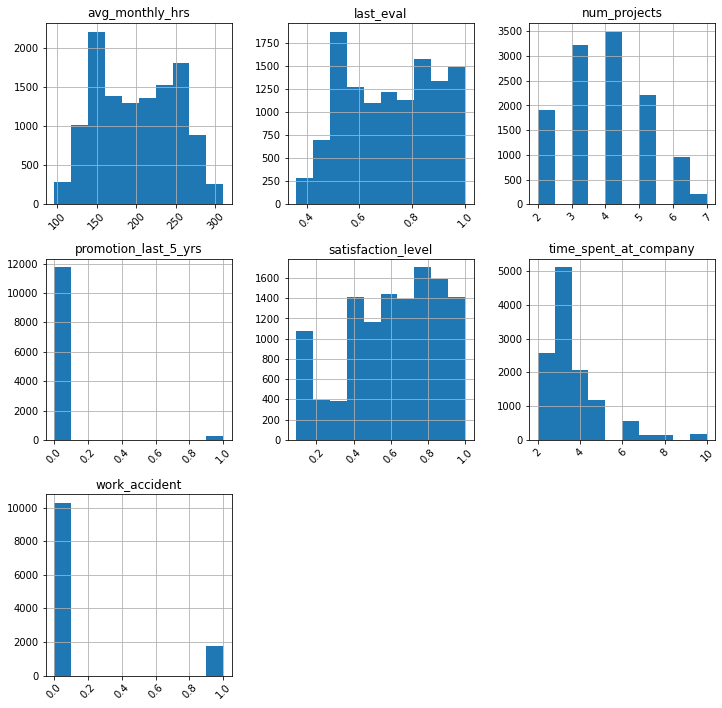

In [19]:
# histograms of numerical fields
# quit - our dependent variable is binary
# promotion in the last 5 years and work accident are also binary
df_full_train.hist(figsize=(12,12), xrot=45)
plt.show()

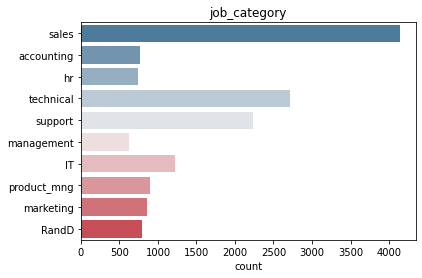

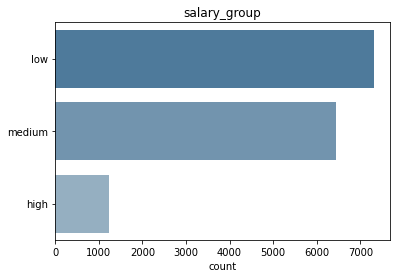

In [20]:
sns.set_palette(sns.diverging_palette(240, 10, n=10))
for column in df_full_train.select_dtypes(include='object'):
    ax = sns.countplot(y=column, data=df)
    ax.set_title(column)
    ax.set_ylabel('')
    plt.show()

In [21]:
# grouping numeric features by each categorical feature
for column in df_full_train.select_dtypes(include='object'):
    display(df_full_train.groupby(column).mean())

,satisfaction_level,last_eval,num_projects,avg_monthly_hrs,time_spent_at_company,work_accident,promotion_last_5_yrs
job_category,,,,,,,
IT,0.617556,0.714622,3.840491,201.781186,3.500000,0.131902,0.001022
RandD,0.615000,0.712843,3.910131,202.390523,3.411765,0.178105,0.026144
accounting,0.580333,0.719445,3.825674,201.445325,3.541997,0.114105,0.017433
hr,0.600632,0.706456,3.626316,196.575439,3.361404,0.121053,0.024561
management,0.621449,0.727735,3.851020,200.485714,4.279592,0.177551,0.114286
marketing,0.613080,0.713518,3.674453,199.093431,3.592701,0.162044,0.048175
product_mng,0.619986,0.714526,3.834262,200.243733,3.484680,0.139276,0.000000
sales,0.613883,0.710912,3.772496,200.569806,3.549776,0.139611,0.024514
support,0.620084,0.725196,3.816201,200.933520,3.378771,0.154190,0.008939


,satisfaction_level,last_eval,num_projects,avg_monthly_hrs,time_spent_at_company,work_accident,promotion_last_5_yrs
salary_group,,,,,,,
high,0.635236,0.703511,3.775154,199.630390,3.719713,0.156057,0.058522
low,0.598501,0.718054,3.807942,201.148066,3.439918,0.141732,0.009243
medium,0.623085,0.717936,3.811692,200.776963,3.542543,0.144125,0.027397


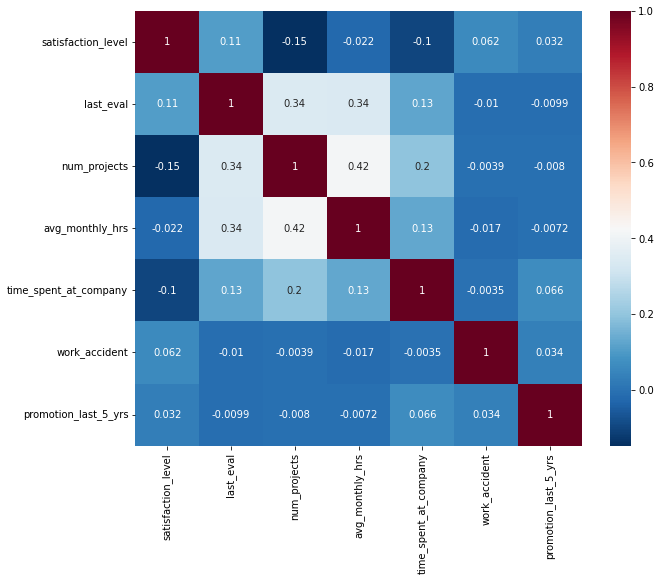

In [22]:
plt.figure(figsize=(10,8))
sns.heatmap(df_full_train.corr(), cmap='RdBu_r', annot=True)
plt.show()

In [23]:
df_full_train.corr()

,satisfaction_level,last_eval,num_projects,avg_monthly_hrs,time_spent_at_company,work_accident,promotion_last_5_yrs
satisfaction_level,1.000000,0.105653,-0.147106,-0.022243,-0.101143,0.061508,0.032071
last_eval,0.105653,1.000000,0.344760,0.341285,0.125342,-0.010322,-0.009895
num_projects,-0.147106,0.344760,1.000000,0.416976,0.195340,-0.003940,-0.008045
avg_monthly_hrs,-0.022243,0.341285,0.416976,1.000000,0.126957,-0.016701,-0.007239
time_spent_at_company,-0.101143,0.125342,0.195340,0.126957,1.000000,-0.003480,0.066272
work_accident,0.061508,-0.010322,-0.003940,-0.016701,-0.003480,1.000000,0.034020
promotion_last_5_yrs,0.032071,-0.009895,-0.008045,-0.007239,0.066272,0.034020,1.000000


In [24]:
mutual_info_score(df_full_train['job_category'], y_full_train)

0.0031640621946582813

In [25]:
mutual_info_score(df_full_train['salary_group'], y_full_train)

0.014193042315226435

<h4>Observations</h4>
<ul>
    <li>As we can see from the histograms, we have an imbalanced dataset (i.e., the classes are not represented equally) with regards to quitting.  So while this is great news for the company that most people kept their jobs, it is not so good for our machine learning models.</li>
    <li>It is also imbalanced with regards to being promoted in the past 5 years or to work accidents.</li>
    <li>Looking at the distributions, it appears that almost no one was promoted within the last 5 years (approximately 2%).</li>
    <li>Work accidents are also fairly infrequent, only 14%, had accidents at work.</li>
    <li>Most workers are in Sales, Technical Jobs or Support.</li>
    <li>The majority of the employees are paid in the "low" category.  We do not have specific details as to what salaries are in low, medium and high.</li>
    <li>It appears that none of our variables are highly correlated.</li>
    <li>We have some slight negative correlation between job satisfaction and the number of projects, average monthly hours, and time spent at the company.  This could be people feeling less happy with their jobs when they are overworked.</li>
    <li>We have some positive correlation between the number of projects and the last evaluation.  Same with the average monthly hours and the last evaluation, as well as, average monthly hours and the number of projects.  This could be managers giving positive evaluations to people getting more done.</li>
    <li>The mutal information score is a univariate metric measuring the relationship between two quanitities.  By knowing one quantity, how confident you would be about knowing the target quantity.  The salary_group is slightly higher than the job_category.  Our mutual information scores are pretty low, indicating the job category and the salary group are pretty independent of knowing whether someone will quit.</li>
</ul>

<h3>Feature Engineering</h3>
<ul>
    <li>Because we have so few variable in this data set, I am reluctant to throw any out, however work accidents and promotions in the past 5 years seem to be few and without providing a lot of information, so we will discard these features.</li>
    <li>Another technique, we could use is a forward or backward stepwise regression to see which features should be included/eliminated to generate the best regression model.</li>
    <li>Many machine learning algorithms are not able to handle imbalanced datasets.  The accuracy score could be misleading.  We can either use a different metric (as mentioned earlier, we will use roc_auc_score instead of accuracy), undersample the majority class, or oversample the minority class.</li>
    <li>Based on the resampling rules of thumb from Dr. Jason Brownlee, <a href="https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/">we should consider over sampling when you do not have a lot of data (tens of thousands of records or less)</a>.  We stratified out train/test split instead of applying resampling techniques to keep things simple.</li>
</ul>   

<h3>Drop the features work_accident and promotion_last_5_yrs</h3>

In [26]:
df_full_train.drop(['work_accident', 'promotion_last_5_yrs'], axis = 1, inplace=True)
df_train.drop(['work_accident', 'promotion_last_5_yrs'], axis = 1, inplace=True)
df_val.drop(['work_accident', 'promotion_last_5_yrs'], axis = 1, inplace=True)
df_test.drop(['work_accident', 'promotion_last_5_yrs'], axis = 1, inplace=True)

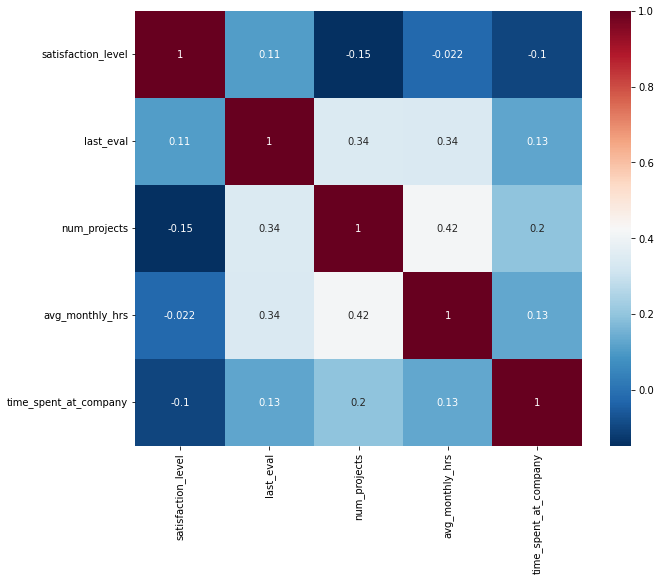

In [27]:
plt.figure(figsize=(10,8))
sns.heatmap(df_full_train.corr(), cmap='RdBu_r', annot=True)
plt.show()

<h3>Encode the Categorical Data</h3>

In [28]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

<h3><a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html">Logistic Regression</a></h3>

In [29]:
lr_model = LogisticRegression(solver='lbfgs')  
lr_model.fit(X_train, y_train)

LogisticRegression()

In [30]:
print('Logistic Regression intercept: {0}'.format(lr_model.intercept_[0]))

Logistic Regression intercept: -0.22848078362987276


In [31]:
print('Logistic Regression coefficients:')
dict(zip(dv.get_feature_names(), lr_model.coef_[0].round(3)))

Logistic Regression coefficients:


{'avg_monthly_hrs': 0.005,
 'job_category=IT': 0.051,
 'job_category=RandD': -0.634,
 'job_category=accounting': 0.256,
 'job_category=hr': 0.315,
 'job_category=management': -0.4,
 'job_category=marketing': -0.008,
 'job_category=product_mng': 0.045,
 'job_category=sales': 0.012,
 'job_category=support': 0.066,
 'job_category=technical': 0.093,
 'last_eval': 0.54,
 'num_projects': -0.328,
 'salary_group=high': -1.13,
 'salary_group=low': 0.762,
 'salary_group=medium': 0.165,
 'satisfaction_level': -4.278,
 'time_spent_at_company': 0.227}

In [32]:
lr_pred = lr_model.predict_proba(X_val)[:, 1]
lr_quit_decision = (lr_pred >= 0.5)
(y_val == lr_quit_decision).mean()

0.772

In [33]:
df_lr_pred = pd.DataFrame()
df_lr_pred['probability'] = lr_pred
df_lr_pred['prediction'] = lr_quit_decision.astype(int)
df_lr_pred['actual'] = y_val
df_lr_pred['correct'] = df_lr_pred.prediction == df_lr_pred.actual
df_lr_pred.head()

,probability,prediction,actual,correct
0,0.767702,1,1,True
1,0.288627,0,0,True
2,0.053197,0,0,True
3,0.097684,0,0,True
4,0.151652,0,0,True


In [34]:
lr_scores  = pd.DataFrame(data = [['Logistic Regression',
                            accuracy_score(y_val, df_lr_pred['prediction']),
                            balanced_accuracy_score(y_val, df_lr_pred['prediction']), 
                            precision_score(y_val, df_lr_pred['prediction']),
                            recall_score(y_val, df_lr_pred['prediction']), 
                            f1_score(y_val, df_lr_pred['prediction']), 
                            roc_auc_score(y_val, df_lr_pred['prediction'])]],
                         columns = ['Model Name','Accuracy','Balanced Accuracy','Precision','Recall','F1','ROC AUC'])
lr_scores

,Model Name,Accuracy,Balanced Accuracy,Precision,Recall,F1,ROC AUC
0,Logistic Regression,0.772,0.612023,0.536765,0.306723,0.390374,0.612023


In [35]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

The Root Mean Squared Error (RMSE) represents how spread out our residuals are. <a href="https://www.researchgate.net/post/Whats-the-acceptable-value-of-Root-Mean-Square-Error-RMSE-Sum-of-Squares-due-to-error-SSE-and-Adjusted-R-square">Based on a rule of thumb</a>, it can be said that RMSE values between 0.2 and 0.5 shows that the model can relatively predict the data accurately. 

In [36]:
print('RMSE: {0}'.format(round(rmse(y_val, df_lr_pred['prediction']),3)))

RMSE: 0.477


<h3><a href="https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html">Decision Trees</a></h3>

We will tune the decision trees a few parameters at a time. Some of the default parameters are criterion='gini', splitter='best'

In [37]:
dt_scores = []

for depth in [4, 5, 6]:
    for s in [1, 10, 15, 20, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        dt_scores.append((depth, s, auc))

In [38]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_dt_scores = pd.DataFrame(dt_scores, columns=columns)

In [39]:
df_dt_scores.sort_values('auc', ascending=False).head(10)

,max_depth,min_samples_leaf,auc
15,6,10,0.977306
14,6,1,0.976965
17,6,20,0.976427
9,5,15,0.976346
10,5,20,0.976131
8,5,10,0.975657
7,5,1,0.975639
16,6,15,0.973730
11,5,100,0.972980
4,4,100,0.970659


<h4>Eye-balling to select the best Decision Tree model, it looks like max_depth =6 and min_samples_leaf = 100</h4>

Here we can see how our Decision Tree splits each node.

In [40]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- satisfaction_level <= 0.47
|   |--- num_projects <= 2.50
|   |   |--- avg_monthly_hrs <= 145.50
|   |   |   |--- class: 1
|   |   |--- avg_monthly_hrs >  145.50
|   |   |   |--- class: 1
|   |--- num_projects >  2.50
|   |   |--- satisfaction_level <= 0.11
|   |   |   |--- class: 1
|   |   |--- satisfaction_level >  0.11
|   |   |   |--- class: 0
|--- satisfaction_level >  0.47
|   |--- time_spent_at_company <= 4.50
|   |   |--- time_spent_at_company <= 3.50
|   |   |   |--- avg_monthly_hrs <= 251.50
|   |   |   |   |--- satisfaction_level <= 0.86
|   |   |   |   |   |--- satisfaction_level <= 0.77
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- satisfaction_level >  0.77
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- satisfaction_level >  0.86
|   |   |   |   |   |--- class: 0
|   |   |   |--- avg_monthly_hrs >  251.50
|   |   |   |   |--- class: 0
|   |   |--- time_spent_at_company >  3.50
|   |   |   |--- class: 0
|   |--- time_spent_at_company >  4.5

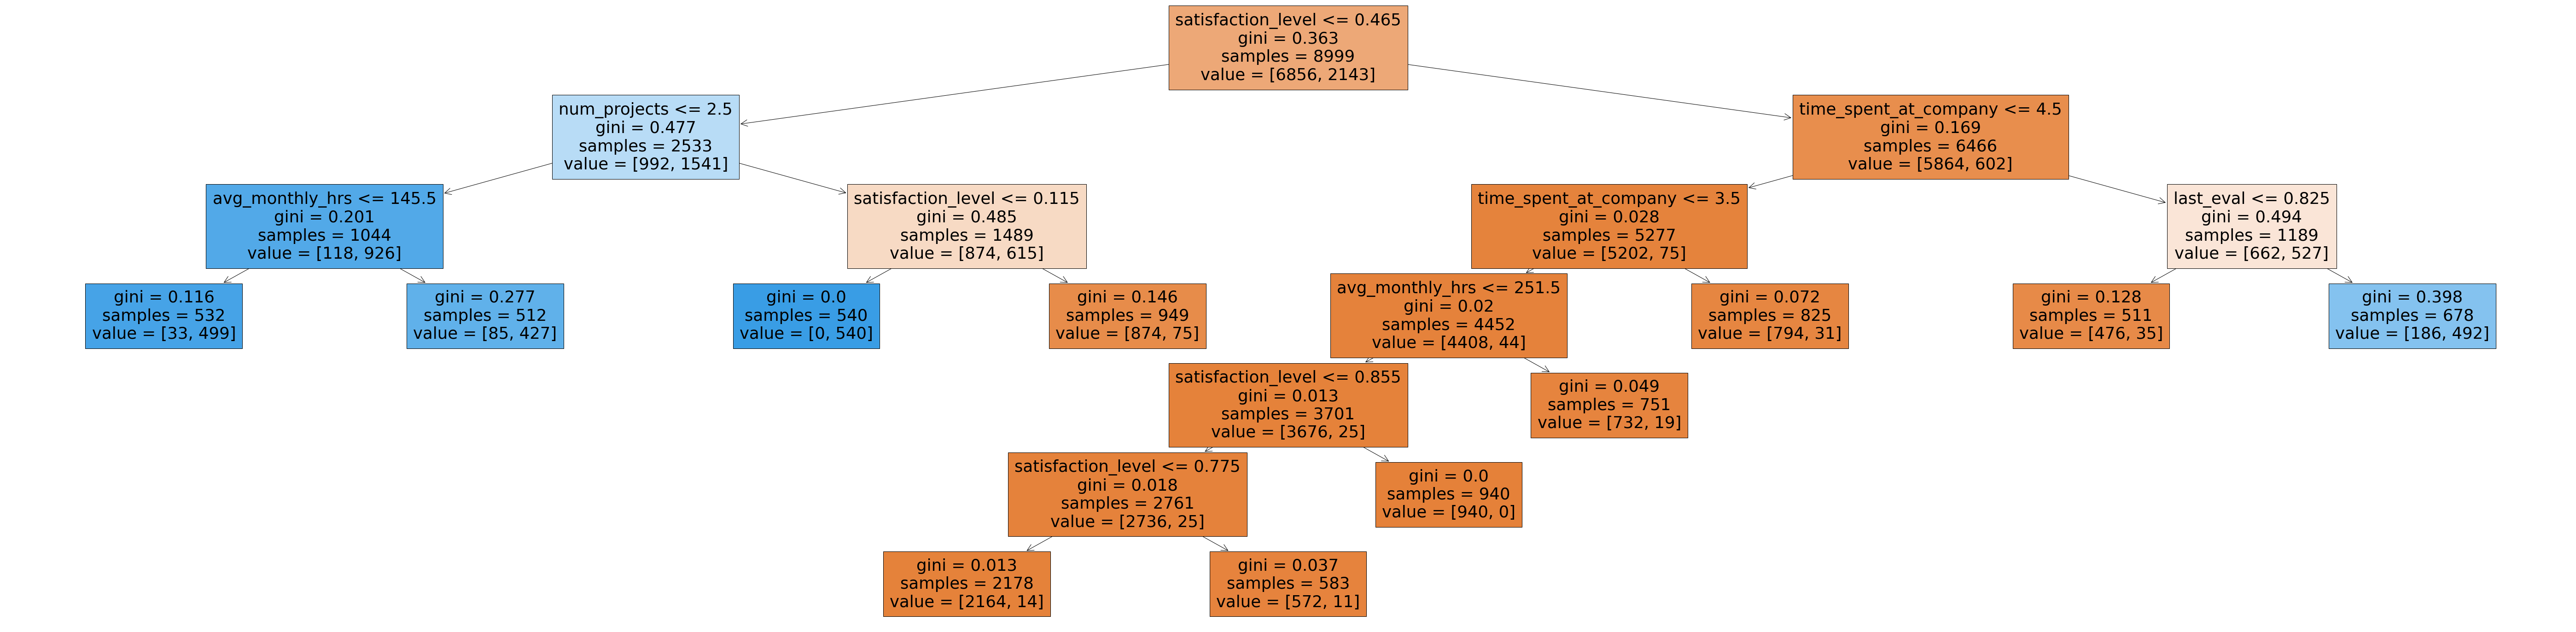

In [41]:
# visualize the decision tree
fig = plt.figure(figsize=(100,25))
plot = tree.plot_tree(dt, feature_names=dv.get_feature_names(), filled=True)
fig.savefig('images/decision_tree.png')

In [42]:
dt_pred = dt.predict(X_val)
dt_scores  = pd.DataFrame(data = [['Decision Tree',
                            accuracy_score(y_val, dt_pred),
                            balanced_accuracy_score(y_val, dt_pred), 
                            precision_score(y_val, dt_pred),
                            recall_score(y_val, dt_pred), 
                            f1_score(y_val, dt_pred), 
                            roc_auc_score(y_val, dt_pred)]],
                         columns = ['Model Name','Accuracy','Balanced Accuracy','Precision','Recall','F1','ROC AUC'])
dt_scores

,Model Name,Accuracy,Balanced Accuracy,Precision,Recall,F1,ROC AUC
0,Decision Tree,0.939333,0.926002,0.852785,0.90056,0.876022,0.926002


<h3><a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html">Random Forest</a></h3>

In [43]:
rf_scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        rf_scores.append((d, n, auc))

In [44]:
columns = ['max_depth', 'n_estimators', 'auc']
df_rf_scores = pd.DataFrame(rf_scores, columns=columns)

In [45]:
df_rf_scores.sort_values('auc', ascending=False).head(10)

,max_depth,n_estimators,auc
58,15,190,0.989955
59,15,200,0.989912
57,15,180,0.989806
56,15,170,0.989694
53,15,140,0.989691
54,15,150,0.989550
55,15,160,0.989514
39,10,200,0.989419
46,15,70,0.989370
45,15,60,0.989197


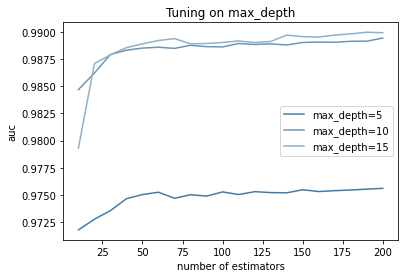

In [46]:
for d in [5, 10, 15]:
    df_subset = df_rf_scores[df_rf_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend();
plt.title('Tuning on max_depth');
plt.xlabel('number of estimators');
plt.ylabel('auc');

<h3>Observations</h3>
When tuning by max_depth and n_estimators, it looks like max_depth = 15 and the n_estimators at 30 give the best AUC. 

In [47]:
rf_max_depth=15

In [48]:
rf_scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=rf_max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        rf_scores.append((s, n, auc))

In [49]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_rf_scores = pd.DataFrame(rf_scores, columns=columns)

In [50]:
df_rf_scores.sort_values('auc', ascending=False).head(10)

,min_samples_leaf,n_estimators,auc
18,1,190,0.989955
19,1,200,0.989912
17,1,180,0.989806
16,1,170,0.989694
13,1,140,0.989691
38,3,190,0.989588
39,3,200,0.989555
14,1,150,0.989550
15,1,160,0.989514
37,3,180,0.989503


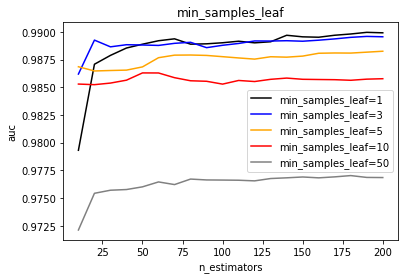

In [51]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_rf_scores[df_rf_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend();
plt.title('min_samples_leaf');
plt.xlabel('n_estimators');
plt.ylabel('auc');

<h3>Observations</h3>
When tuning by min_samples_leaf and n_estimators, it looks like min_samples_leaf = 1 and the n_estimators at 190 give the best AUC. 

In [52]:
rf_min_samples_leaf = 1

In [53]:
rf_scores = []

for b in [True, False]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=rf_max_depth,
                                    min_samples_leaf=rf_min_samples_leaf,
                                    bootstrap=b,
                                    random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        rf_scores.append((b, n, auc))

In [54]:
columns = ['bootstrap', 'n_estimators', 'auc']
df_rf_scores = pd.DataFrame(rf_scores, columns=columns)

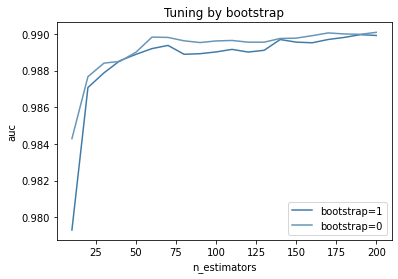

In [55]:
for b in [True, False]:
    df_subset = df_rf_scores[df_rf_scores.bootstrap == b]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='bootstrap=%d' % b)

plt.legend();
plt.title('Tuning by bootstrap');
plt.xlabel('n_estimators');
plt.ylabel('auc');

<h3>Based on our tuning, we will use 190 estimators, no bootstrapping, max depth of 15, min sample leafs of 1</h3>

In [56]:
rf_n_estimators=190
rf_bootstrap=True

In [57]:
rf = RandomForestClassifier(n_estimators=rf_n_estimators,
                            max_depth=rf_max_depth,
                            min_samples_leaf=rf_min_samples_leaf,
                            bootstrap=rf_bootstrap,
                            random_state=1)
rf.fit(X_train, y_train)
rf_pred = rf.predict_proba(X_val)[:, 1]
rf_quit_decision = (rf_pred >= 0.5)
(y_val == rf_quit_decision).mean()

0.984

In [58]:
df_rf_pred = pd.DataFrame()
df_rf_pred['probability'] = rf_pred
df_rf_pred['prediction'] = rf_quit_decision.astype(int)
df_rf_pred['actual'] = y_val
df_rf_pred['correct'] = df_rf_pred.prediction == df_rf_pred.actual
df_rf_pred.head()

,probability,prediction,actual,correct
0,0.999095,1,1,True
1,0.004627,0,0,True
2,0.002400,0,0,True
3,0.000665,0,0,True
4,0.000888,0,0,True


In [59]:
rf_scores  = pd.DataFrame(data = [['Random Forest',
                            accuracy_score(y_val, df_rf_pred['prediction']),
                            balanced_accuracy_score(y_val, df_rf_pred['prediction']), 
                            precision_score(y_val, df_rf_pred['prediction']),
                            recall_score(y_val, df_rf_pred['prediction']), 
                            f1_score(y_val, df_rf_pred['prediction']), 
                            roc_auc_score(y_val, df_rf_pred['prediction'])]],
                         columns = ['Model Name','Accuracy','Balanced Accuracy','Precision','Recall','F1','ROC AUC'])
rf_scores

,Model Name,Accuracy,Balanced Accuracy,Precision,Recall,F1,ROC AUC
0,Random Forest,0.984,0.969757,0.989706,0.942577,0.965567,0.969757


In [60]:
list(zip(dv.feature_names_, rf.feature_importances_))

[('avg_monthly_hrs', 0.15295774022051173),
 ('job_category=IT', 0.0015311842406276217),
 ('job_category=RandD', 0.001327980086024757),
 ('job_category=accounting', 0.00155465445090829),
 ('job_category=hr', 0.0010557754210680094),
 ('job_category=management', 0.0018676481157455737),
 ('job_category=marketing', 0.0007865462531288646),
 ('job_category=product_mng', 0.0012598875090326775),
 ('job_category=sales', 0.0032473294422041424),
 ('job_category=support', 0.00261112501438414),
 ('job_category=technical', 0.003390633517654454),
 ('last_eval', 0.12515171022819643),
 ('num_projects', 0.18063105517737374),
 ('salary_group=high', 0.004124237725972358),
 ('salary_group=low', 0.008698248696051483),
 ('salary_group=medium', 0.003668778596678478),
 ('satisfaction_level', 0.3238533565180249),
 ('time_spent_at_company', 0.18228210878641243)]

In [61]:
#feature importances 
fi = pd.DataFrame({'Feature': dv.feature_names_, 'Score': rf.feature_importances_})
sortedfi = fi.sort_values('Score', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')
sortedfi.style.highlight_max(axis=0)

,Feature,Score
16,satisfaction_level,0.323853
17,time_spent_at_company,0.182282
12,num_projects,0.180631
0,avg_monthly_hrs,0.152958
11,last_eval,0.125152
14,salary_group=low,0.008698
13,salary_group=high,0.004124
15,salary_group=medium,0.003669
10,job_category=technical,0.003391
8,job_category=sales,0.003247


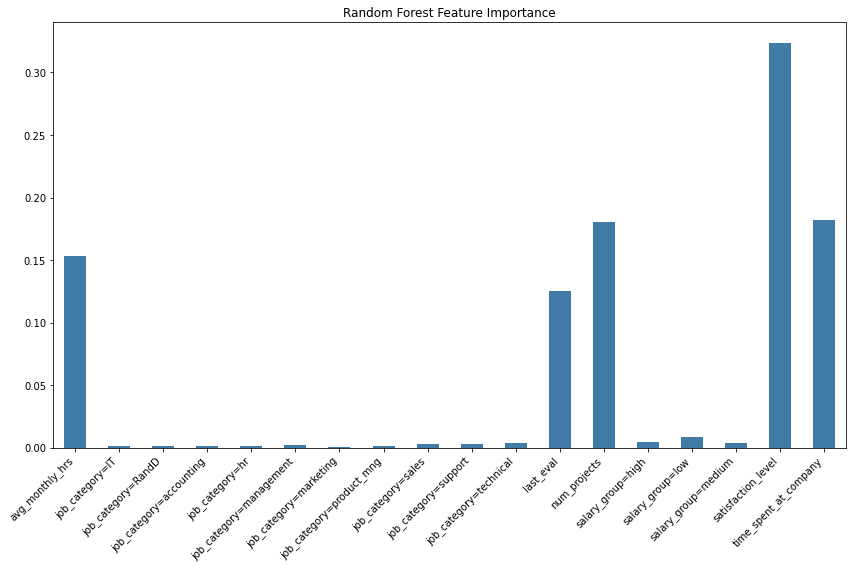

In [62]:
rf_import = pd.Series(rf.feature_importances_, index=dv.feature_names_)
fig, ax = plt.subplots(figsize=(12,8))
rf_import.plot.bar()
ax.set_title("Random Forest Feature Importance")
plt.xticks(rotation=45, ha='right')
fig.tight_layout()

<h3><a href="https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html">Support Vector Machines</a></h3>

In [63]:
svm_clf = svm.SVC(kernel='linear', random_state=1)
svm_clf.fit(X_train, y_train)
svm_pred = svm_clf.predict(X_val)

In [64]:
svm_scores = pd.DataFrame(data= [['SVM',
                                  accuracy_score(y_val, svm_pred),
                                  balanced_accuracy_score(y_val, svm_pred),
                                  precision_score(y_val, svm_pred),
                                  recall_score(y_val, svm_pred),
                                  f1_score(y_val, svm_pred),
                                  roc_auc_score(y_val, svm_pred)]],
                          columns = ['Model Name','Accuracy','Balanced Accuracy','Precision','Recall','F1','ROC AUC'])
svm_scores

,Model Name,Accuracy,Balanced Accuracy,Precision,Recall,F1,ROC AUC
0,SVM,0.769667,0.591229,0.534328,0.2507,0.341277,0.591229


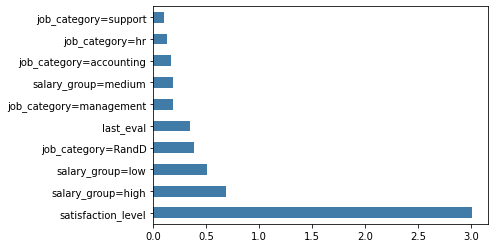

In [65]:
pd.Series(abs(svm_clf.coef_[0]), index=dv.get_feature_names()).nlargest(10).plot(kind='barh');

<h3><a href="https://xgboost.readthedocs.io/en/latest/python/index.html">XGBoost</a></h3>

In [66]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [67]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [68]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

<h3>testing eta (learning rate)</h3>

In [69]:
xgb_params1 = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

In [70]:
xgb_params2 = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

In [71]:
xgb_params3 = {
    'eta': 0.1, 
    'max_depth': 10,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

<h4>XBG Model 1</h4>

In [72]:
%%capture output
xgb_model1 = xgb.train(xgb_params1, dtrain, num_boost_round=200, verbose_eval=5, evals=watchlist)

In [73]:
df_xgb_score1 = parse_xgb_output(output)

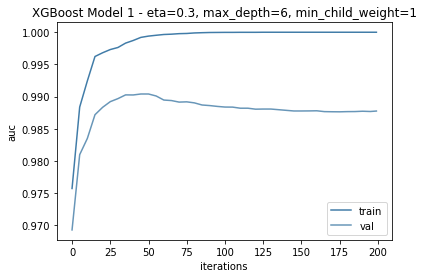

In [74]:
plt.plot(df_xgb_score1.num_iter, df_xgb_score1.train_auc, label='train')
plt.plot(df_xgb_score1.num_iter, df_xgb_score1.val_auc, label='val')
plt.legend();
plt.title('XGBoost Model 1 - eta=0.3, max_depth=6, min_child_weight=1');
plt.xlabel('iterations');
plt.ylabel('auc');

<h4>XGB Model 2</h4>

In [75]:
%%capture output
xgb_model2 = xgb.train(xgb_params2, dtrain, num_boost_round=200, verbose_eval=5, evals=watchlist)

In [76]:
df_xgb_score2 = parse_xgb_output(output)

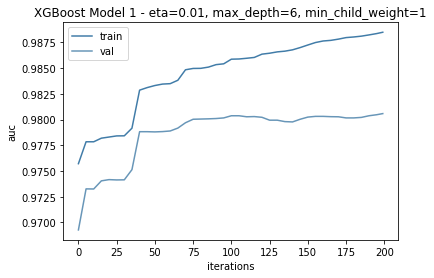

In [77]:
plt.plot(df_xgb_score2.num_iter, df_xgb_score2.train_auc, label='train')
plt.plot(df_xgb_score2.num_iter, df_xgb_score2.val_auc, label='val')
plt.legend();
plt.title('XGBoost Model 1 - eta=0.01, max_depth=6, min_child_weight=1');
plt.xlabel('iterations');
plt.ylabel('auc');

<h4>XGB Model 3</h4>

In [78]:
%%capture output
xgb_model3 = xgb.train(xgb_params3, dtrain, num_boost_round=200, verbose_eval=5, evals=watchlist)

In [79]:
df_xgb_score3 = parse_xgb_output(output)

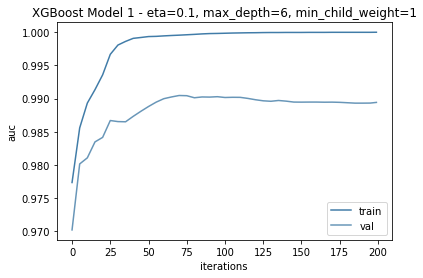

In [80]:
plt.plot(df_xgb_score3.num_iter, df_xgb_score3.train_auc, label='train')
plt.plot(df_xgb_score3.num_iter, df_xgb_score3.val_auc, label='val')
plt.legend();
plt.title('XGBoost Model 1 - eta=0.1, max_depth=6, min_child_weight=1');
plt.xlabel('iterations');
plt.ylabel('auc');

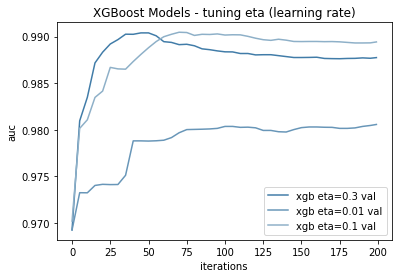

In [81]:
plt.plot(df_xgb_score1.num_iter, df_xgb_score1.val_auc, label='xgb eta=0.3 val')
plt.plot(df_xgb_score2.num_iter, df_xgb_score2.val_auc, label='xgb eta=0.01 val')
plt.plot(df_xgb_score3.num_iter, df_xgb_score3.val_auc, label='xgb eta=0.1 val')
plt.legend();
plt.title('XGBoost Models - tuning eta (learning rate)');
plt.xlabel('iterations');
plt.ylabel('auc');

It looks like eta=0.1 did the best.

<h3>tuning on max_depth and holding eta=0.1</h3>

In [82]:
xgb_params4 = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1, 
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

In [83]:
xgb_params5 = {
    'eta': 0.1, 
    'max_depth': 5,
    'min_child_weight': 1, 
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

<h4>XBG Model 4</h4>

In [84]:
%%capture output
xgb_model4 = xgb.train(xgb_params4, dtrain, num_boost_round=200, verbose_eval=5, evals=watchlist)

In [85]:
df_xgb_score4= parse_xgb_output(output)

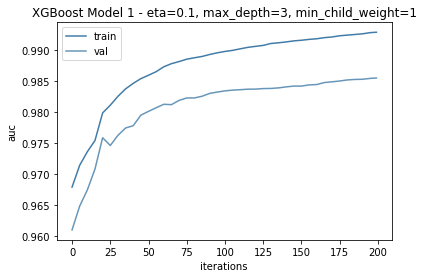

In [86]:
plt.plot(df_xgb_score4.num_iter, df_xgb_score4.train_auc, label='train')
plt.plot(df_xgb_score4.num_iter, df_xgb_score4.val_auc, label='val')
plt.legend();
plt.title('XGBoost Model 1 - eta=0.1, max_depth=3, min_child_weight=1');
plt.xlabel('iterations');
plt.ylabel('auc');

<h4>XGB Model 5</h4>

In [87]:
%%capture output
xgb_model5 = xgb.train(xgb_params5, dtrain, num_boost_round=200, verbose_eval=5, evals=watchlist)

In [88]:
df_xgb_score5= parse_xgb_output(output)

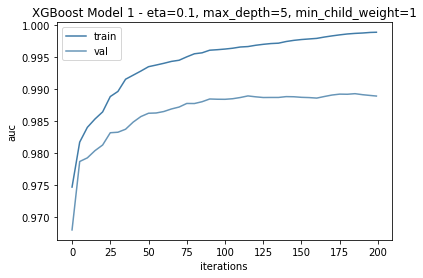

In [89]:
plt.plot(df_xgb_score5.num_iter, df_xgb_score5.train_auc, label='train')
plt.plot(df_xgb_score5.num_iter, df_xgb_score5.val_auc, label='val')
plt.legend();
plt.title('XGBoost Model 1 - eta=0.1, max_depth=5, min_child_weight=1');
plt.xlabel('iterations');
plt.ylabel('auc');

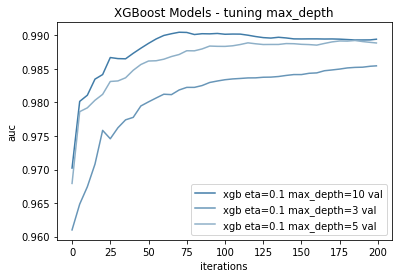

In [90]:
plt.plot(df_xgb_score3.num_iter, df_xgb_score3.val_auc, label='xgb eta=0.1 max_depth=10 val')
plt.plot(df_xgb_score4.num_iter, df_xgb_score4.val_auc, label='xgb eta=0.1 max_depth=3 val')
plt.plot(df_xgb_score5.num_iter, df_xgb_score5.val_auc, label='xgb eta=0.1 max_depth=5 val')
plt.legend();
plt.title('XGBoost Models - tuning max_depth');
plt.xlabel('iterations');
plt.ylabel('auc');

<h3>Looks like max_depth of 10 does the best. So we will select XGB Model 3.</h3>

There are a lot more parameters we could tune on, but we will stop here and go with what we have.

In [91]:
xgb_pred = xgb_model3.predict(dval)
xgb_quit_decision = (xgb_pred >= 0.5)

In [92]:
df_xgb_pred = pd.DataFrame()
df_xgb_pred['probability'] = xgb_pred
df_xgb_pred['prediction'] = xgb_quit_decision.astype(int)
df_xgb_pred['actual'] = y_val
df_xgb_pred['correct'] = df_xgb_pred.prediction == df_xgb_pred.actual
df_xgb_pred.head()

,probability,prediction,actual,correct
0,0.999714,1,1,True
1,0.000687,0,0,True
2,0.001022,0,0,True
3,0.000804,0,0,True
4,0.000709,0,0,True


In [93]:
xgb_scores  = pd.DataFrame(data = [['XGBoost',
                            accuracy_score(y_val, df_xgb_pred['prediction']),
                            balanced_accuracy_score(y_val, df_xgb_pred['prediction']), 
                            precision_score(y_val, df_xgb_pred['prediction']),
                            recall_score(y_val, df_xgb_pred['prediction']), 
                            f1_score(y_val, df_xgb_pred['prediction']), 
                            roc_auc_score(y_val, df_xgb_pred['prediction'])]],
                         columns = ['Model Name','Accuracy','Balanced Accuracy','Precision','Recall','F1','ROC AUC'])
xgb_scores

,Model Name,Accuracy,Balanced Accuracy,Precision,Recall,F1,ROC AUC
0,XGBoost,0.986333,0.976586,0.984173,0.957983,0.970901,0.976586


<h3>Selecting a Model</h3>

In [94]:
model_scores = pd.concat([lr_scores, dt_scores, rf_scores, svm_scores, xgb_scores])
model_scores.sort_values('ROC AUC', ascending=False)

,Model Name,Accuracy,Balanced Accuracy,Precision,Recall,F1,ROC AUC
0,XGBoost,0.986333,0.976586,0.984173,0.957983,0.970901,0.976586
0,Random Forest,0.984000,0.969757,0.989706,0.942577,0.965567,0.969757
0,Decision Tree,0.939333,0.926002,0.852785,0.900560,0.876022,0.926002
0,Logistic Regression,0.772000,0.612023,0.536765,0.306723,0.390374,0.612023
0,SVM,0.769667,0.591229,0.534328,0.250700,0.341277,0.591229


Based on the ROC AUC metric, it appears the both Random Forest and XGBoost perform very well on our validation data.

<h3>Train on the full train dataset (training and validation) and evaluate on the test data</h3>

In [95]:
dicts_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [96]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train, feature_names=dv.get_feature_names())
dtest = xgb.DMatrix(X_test, feature_names=dv.get_feature_names())

<h3>XGBoost</h3>

In [97]:
xgb_params = {'colsample_bytree': 0.5,
              'gamma': 1,
              'learning_rate': 0.1,
              'objective': 'binary:logistic',
              'max_depth': 3,
              'reg_lambda': 0,
              'scale_pos_weight': 3,
              'seed': 1,
              'subsample': 0.8,
              'nthread': 8,
              'verbosity': 1}

xgb_model = xgb.train(xgb_params, dfulltrain, num_boost_round=10)
xgb_pred = xgb_model.predict(dtest)
xgb_quit_decision = (xgb_pred >= 0.5)

[15:51:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [98]:
xgb_f_scores  = pd.DataFrame(data = [['XGBoost (Full Train)',
                            accuracy_score(y_val, xgb_quit_decision.astype(int)),
                            balanced_accuracy_score(y_val, xgb_quit_decision.astype(int)), 
                            precision_score(y_val, xgb_quit_decision.astype(int)),
                            recall_score(y_val, xgb_quit_decision.astype(int)), 
                            f1_score(y_val, xgb_quit_decision.astype(int)), 
                            roc_auc_score(y_val, xgb_quit_decision.astype(int))]],
                         columns = ['Model Name','Accuracy','Balanced Accuracy','Precision','Recall','F1','ROC AUC'])
xgb_f_scores

,Model Name,Accuracy,Balanced Accuracy,Precision,Recall,F1,ROC AUC
0,XGBoost (Full Train),0.626333,0.495734,0.231884,0.246499,0.238968,0.495734


In [99]:
roc_auc_score(y_val, xgb_pred)

0.5020502951836903

<h3>Random Forest</h3>

In [100]:
# random forest parameters
rf_max_depth=15
rf_min_samples_leaf = 1
rf_n_estimators=190
rf_bootstrap=False
rf_random_state=1

In [101]:
rf = RandomForestClassifier(n_estimators=rf_n_estimators,
                            max_depth=rf_max_depth,
                            min_samples_leaf=rf_min_samples_leaf,
                            bootstrap=rf_bootstrap,
                            random_state=rf_random_state)
rf.fit(X_full_train, y_full_train)
rf_pred = rf.predict_proba(X_test)[:, 1]
rf_quit_decision = (rf_pred >= 0.5)

In [102]:
rf_f_scores  = pd.DataFrame(data = [['Random Forest (Full Train)',
                            accuracy_score(y_val, rf_quit_decision.astype(int)),
                            balanced_accuracy_score(y_val, rf_quit_decision.astype(int)), 
                            precision_score(y_val, rf_quit_decision.astype(int)),
                            recall_score(y_val, rf_quit_decision.astype(int)), 
                            f1_score(y_val, rf_quit_decision.astype(int)), 
                            roc_auc_score(y_val, rf_quit_decision.astype(int))]],
                         columns = ['Model Name','Accuracy','Balanced Accuracy','Precision','Recall','F1','ROC AUC'])
rf_f_scores

,Model Name,Accuracy,Balanced Accuracy,Precision,Recall,F1,ROC AUC
0,Random Forest (Full Train),0.641,0.501505,0.240343,0.235294,0.237792,0.501505


In [103]:
final_model_scores = pd.concat([rf_f_scores, xgb_f_scores])
final_model_scores.sort_values('ROC AUC', ascending=False)

,Model Name,Accuracy,Balanced Accuracy,Precision,Recall,F1,ROC AUC
0,Random Forest (Full Train),0.641000,0.501505,0.240343,0.235294,0.237792,0.501505
0,XGBoost (Full Train),0.626333,0.495734,0.231884,0.246499,0.238968,0.495734


<h3>Observations</h3>
Overall, neither model performed well on the test dataset. You want the ROC AUC scores to be > .5. If there were more time, I would experiment more.
Since the Random Forest model had slightly higher scores for everything across the board, so we will choose it for deployment.

As you may have guessed, Job Satisfaction seems to be the biggest driver of someone quitting.

<h3>Export the model for deployment</h3>

In [104]:
def train(df_train, y_train, n_estimators, max_depth, min_samples_leaf, bootstrap, random_state):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    rf_model = RandomForestClassifier(n_estimators=n_estimators,
                                      max_depth=max_depth,
                                      min_samples_leaf=min_samples_leaf,
                                      bootstrap=bootstrap,
                                      random_state=random_state)
    rf_model.fit(X_train, y_train)
    
    return dv, rf_model

In [105]:
def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [106]:
dv, rf_model = train(df_full_train, y_full_train, rf_n_estimators, rf_max_depth, rf_min_samples_leaf, rf_bootstrap, rf_random_state)

In [107]:
output_file = 'rf_model.bin'

with open(output_file, 'wb') as f_out: 
    pickle.dump((dv, rf), f_out)

<h4>Model Parameters</h4>

In [108]:
rf_n_estimators, rf_max_depth, rf_min_samples_leaf, rf_bootstrap, rf_random_state

(190, 15, 1, False, 1)

<a id='reference'></a>
# Reference

[HR Retention Prediction dataset by Vincent Tatan](https://github.com/VincentTatan/PythonAnalytics/blob/master/Youtube/dataset/HR_comma_sep.csv) *last updated on github 1/18/17*

[The geography of the Great Resignation: First-time data shows where Americans are quitting the most](https://www.washingtonpost.com/business/2021/10/22/states-labor-quitting-turnvoer-jolts/)
by Alyssa Fowers and Eli Rosenberg, *published: 10/22/21, accessed: 10/23/21*

[The Great Resignation: Why People Are Leaving Their Jobs In Growing Numbers](https://www.npr.org/2021/10/22/1048332481/the-great-resignation-why-people-are-leaving-their-jobs-in-growing-numbers)
*published: 10/22/21, accessed: 10/23/21*

[Why are so many Americans quitting their jobs?](https://www.npr.org/sections/money/2021/10/19/1047032996/why-are-so-many-americans-quitting-their-jobs)
by Greg Rosalsky, *published: 10/19/21, accessed: 10/23/21*

[The ‘Great Resignation’ Is A Workers’ Revolution: Here’s What Real Leaders Must Do Right Now](https://www.forbes.com/sites/jackkelly/2021/10/08/the-great-resignation-is-a-workers-revolution-heres-what-real-leaders-must-do-right-now/?sh=5c2b453f514f) by Jack Kelly, *published: 10/8/21; accessed: 10/23/21*

[The Great Resignation Update: Limeade Employee Care Report](https://www.limeade.com/resources/resource-center/limeade-employee-care-report-the-great-resignation-update/) *accessed: 10/23/21*

[The Great Resignation Is Accelerating: A lasting effect of this pandemic will be a revolution in worker expectations.](https://www.theatlantic.com/ideas/archive/2021/10/great-resignation-accelerating/620382/) by Derek Thompson, *published: 10/15/21, accessed: 10/23/21*

[The Great Resignation is no joke](https://fortune.com/2021/10/21/the-great-resignation-is-no-joke/) by Lance Lambert, *published: 10/21/21, accessed: 10/23/21*

[US Bureau of Labor Statistics: Table 4. Quits levels and rates by industry and region, seasonally adjusted](https://www.bls.gov/news.release/jolts.t04.htm) *published: 10/12/21, accessed: 10/23/21*

[‘Micromanaged and disrespected’: Top reasons workers are quitting their jobs in ‘The Great Resignation’
Health concerns, increased workloads, unrealistic manager expectations are pushing many to the breaking point, readers tell me. And those who can afford to quit or take early retirement are leaving. ](https://www.washingtonpost.com/business/2021/10/07/top-reasons-great-resignation-workers-quitting/)
by Karla L. Miller, *published: 10/7/21, accessed: 10/23/21*

[During the ‘Great Resignation,’ workers refuse to accept the unacceptable
People who are used to tolerating bad work situations are increasingly leaving their jobs and demanding better working conditions](https://www.washingtonpost.com/business/2021/09/30/during-great-resignation-workers-refuse-accept-unacceptable/)by Karla L. Miller, *published: 9/30/21, accessed: 10/23/21*

[Who Is Driving the Great Resignation?](https://hbr.org/2021/09/who-is-driving-the-great-resignation)
by Ian Cook
*published: 9/15/21, accessed: 10/23/21*

[As The Pandemic Recedes, Millions Of Workers Are Saying 'I Quit'](https://www.npr.org/2021/06/24/1007914455/as-the-pandemic-recedes-millions-of-workers-are-saying-i-quit)
by Andrea Hsu, *published: 6/24/21, accessed: 10/23/21*

[Wikipedia: The Great Resignation](https://en.wikipedia.org/wiki/Great_Resignation)
*accessed: 10/23/21*